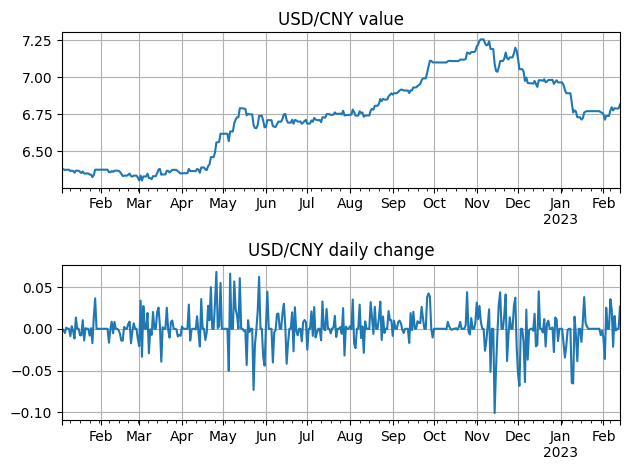

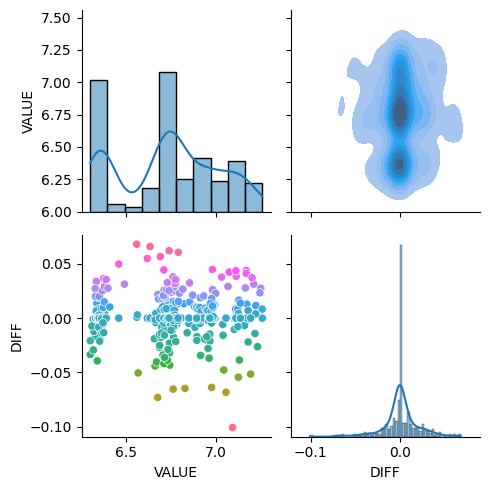

In [2]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

import seaborn as sns

import ConnectSQLdb
from ConnectSQLdb import config

engine = create_engine(f"mysql+pymysql://{config['user']}:{config['password']}@{config['host']}/{config['database']}", echo=False)

# Get data for USD/CNY 
sql = ("SELECT DATE, NOMINAL, VALUE FROM currencies "
       "WHERE SOURCE = 'CFETS' AND CURRENCY = 'USD/CNY';")
df1 = pd.read_sql(sql, con=engine)

idx = pd.date_range(min(df1.DATE), max(df1.DATE))
df1 = df1.set_index("DATE")
df1 = df1.reindex(idx)
df1 = df1.fillna(method='ffill')

df1['DIFF'] = df1.VALUE - df1.VALUE.shift(1)
df1.DIFF = df1.DIFF.fillna(0)


plt.rcParams["figure.autolayout"] = True
fig, axes = plt.subplots(2,1)
df1.drop("NOMINAL", axis=1).VALUE.plot(ax=axes[0], grid=True, title='USD/CNY value')
df1.drop("NOMINAL", axis=1).DIFF.plot(ax=axes[1], grid=True, title='USD/CNY daily change')

g = sns.PairGrid(df1.drop("NOMINAL", axis=1))
g.map_diag(sns.histplot, kde=True)
g.map_upper(sns.kdeplot, fill=True)
g.map_lower(sns.scatterplot, hue=df1.DIFF, palette='husl');

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(df1.VALUE,model = 'add')
#result_add.plot();
result_mul = seasonal_decompose(df1.VALUE,model = 'mul')
#result_mul.plot();

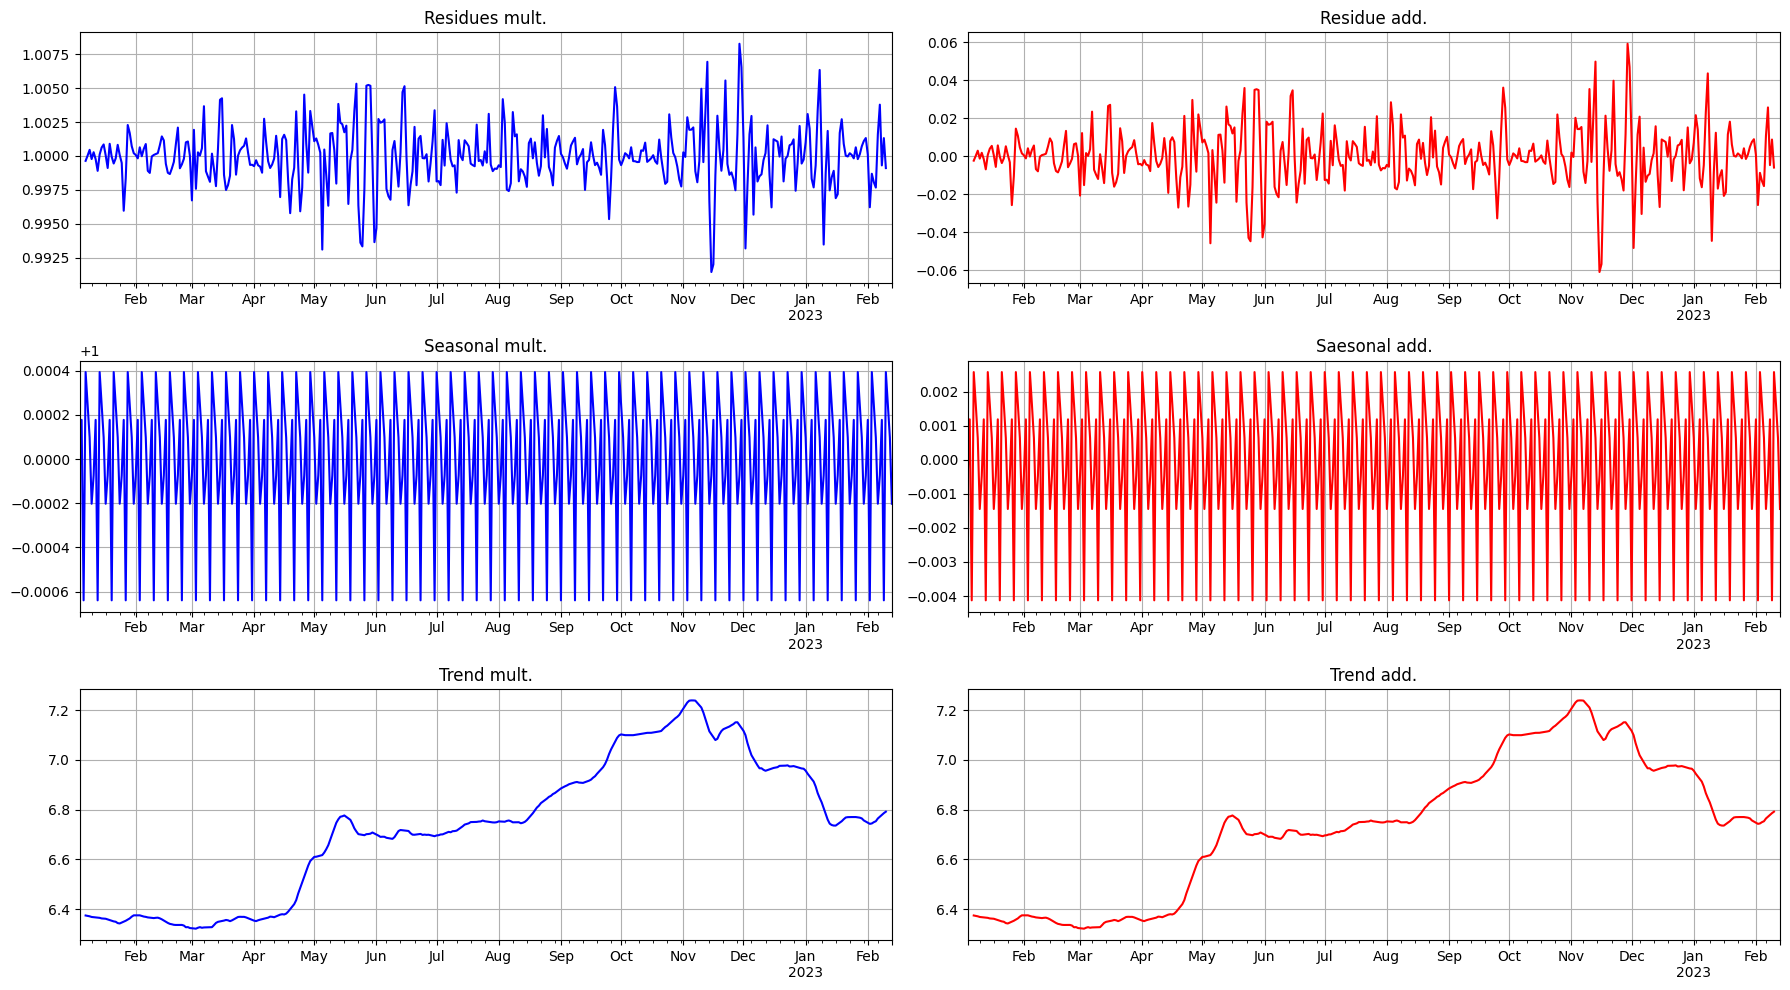

In [4]:
fig, axes = plt.subplots(3,2)
fig.set_size_inches(18,10)
resid_mul = result_mul.resid
seasonal_mul = result_mul.seasonal
trend_mul = result_mul.trend
resid_mul.plot(color='blue', ax=axes[0,0], title='Residues mult.', grid=True)
seasonal_mul.plot(color='blue', ax=axes[1,0], title='Seasonal mult.', grid=True)
trend_mul.plot(color='blue', ax=axes[2,0], title='Trend mult.', grid=True);
resid_add = result_add.resid
seasonal_add = result_add.seasonal
trend_add = result_add.trend
resid_add.plot(color='red', ax=axes[0,1], title='Residue add.', grid=True)
seasonal_add.plot(color='red', ax=axes[1,1], title='Saesonal add.', grid=True)
trend_add.plot(color='red', ax=axes[2,1], title='Trend add.', grid=True);

c:\Users\Fraynt\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\Fraynt\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


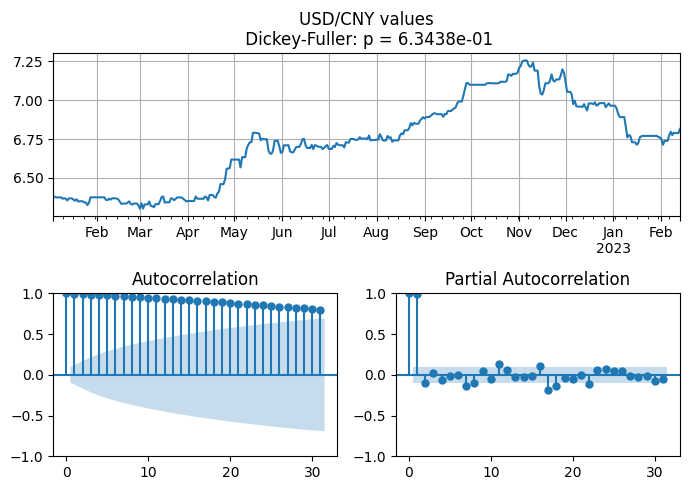

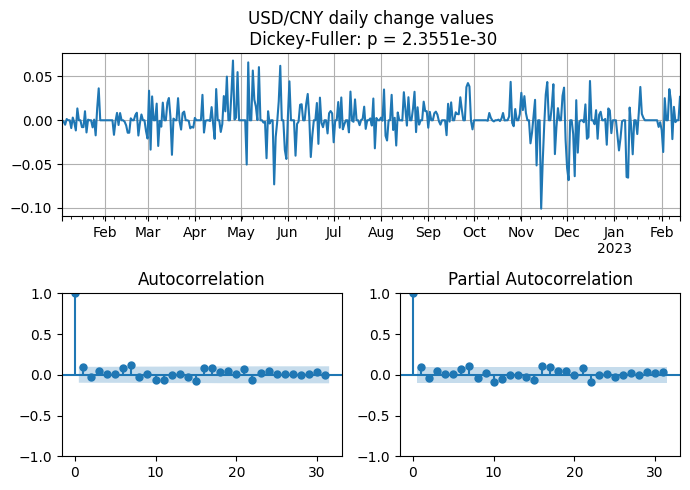

In [52]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

def plot_correl(series, name):
    p_value = sm.tsa.stattools.adfuller(series)

    fig, axes = plt.subplot_mosaic([['A', 'A'], ['B', 'C']])
    fig.set_size_inches(7,5)
    series.plot(ax=axes['A'], title=f"{name} values\n Dickey-Fuller: p = {p_value[1]:0.4e}", grid=True);
    smt.graphics.plot_acf(series, lags=31, ax=axes['B']);
    smt.graphics.plot_pacf(series, lags=31, ax=axes['C']);
plot_correl(df1.VALUE, 'USD/CNY')
plot_correl(df1.DIFF, 'USD/CNY daily change')

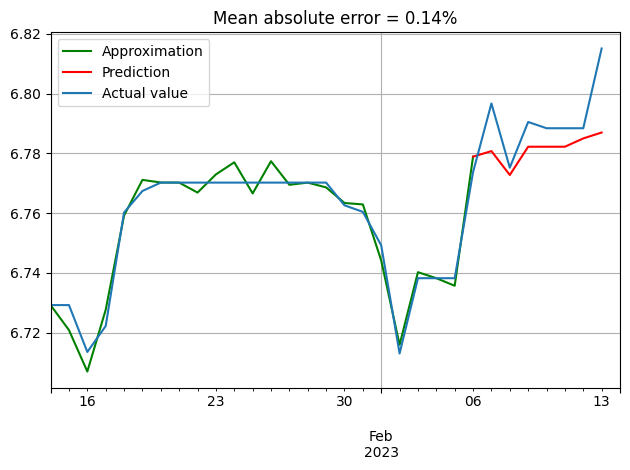

In [154]:
train = df1[:int(len(df1)-7)]
test = df1[-7: ]

model =  sm.tsa.SARIMAX(
    endog=train.VALUE, 
    order=(1,1,0),
    seasonal_order=(1,1,1,7)
).fit()

model.summary()

def mse_p(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

y_approx = model.predict(len(df1)-31, len(df1)-7).shift(-1)
y_approx.plot(color='green')
y_pred = model.predict(len(df1)-8, len(df1)).shift(-1)
y_pred.plot(color='red')
df1.VALUE[-31:].plot()
plt.legend(['Approximation','Prediction', 'Actual value']);
plt.grid()
plt.title(f"Mean absolute error = {mse_p(df1.VALUE[-8:],y_pred):0.2%}");